[5.  4.5 5.5 6.  7.  6.5 7.5 8. ]
8
[3.5 3.  4.  4.5 2.5 2. ]
6


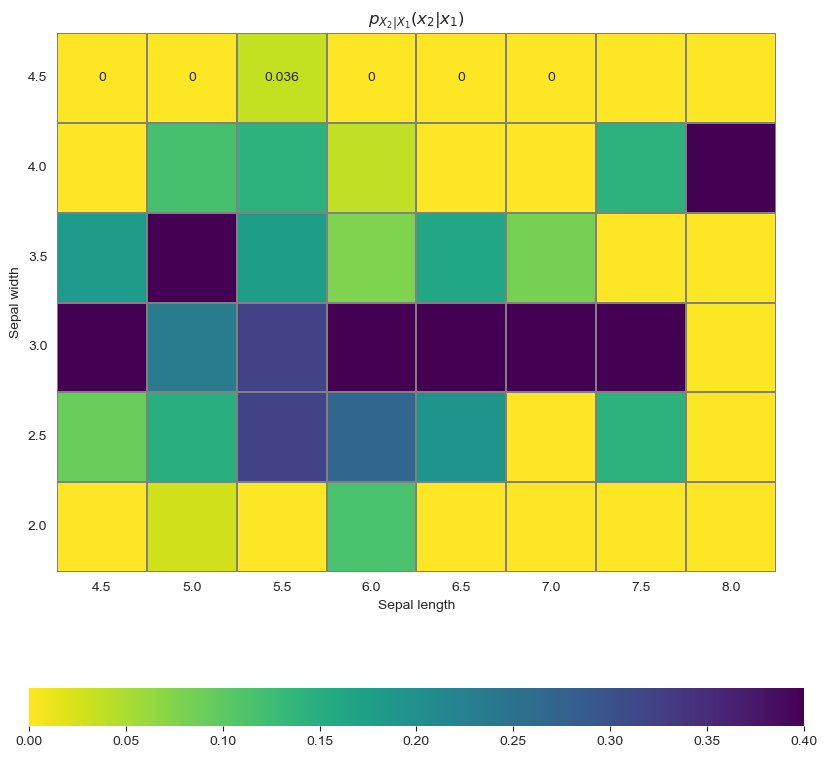

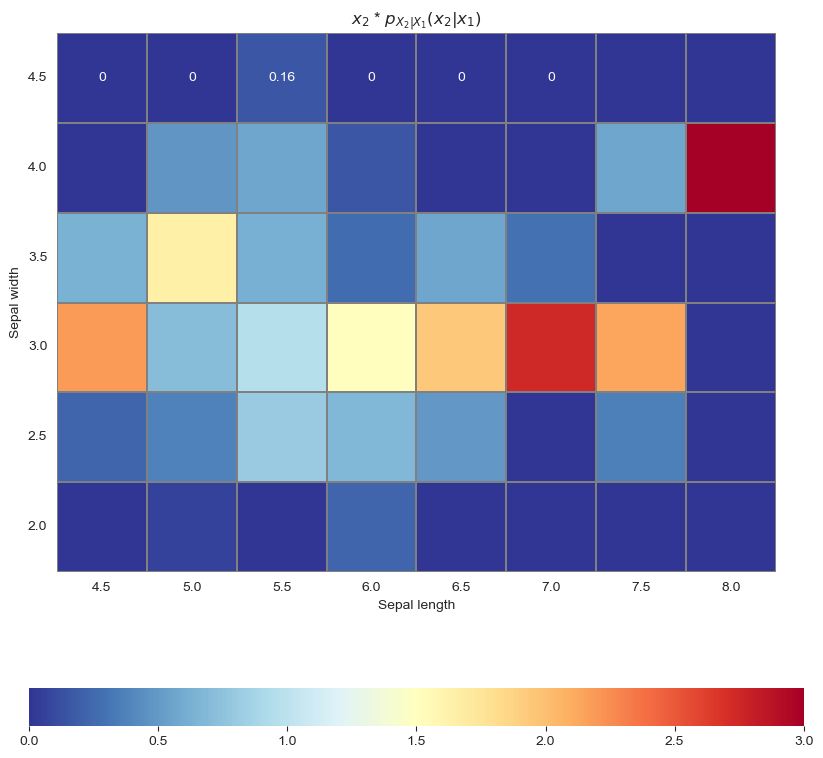

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_iris

pd.options.mode.chained_assignment = None  # default='warn'  关闭链式赋值警告

# Load the iris data
X_df = sns.load_dataset("iris", cache=False, data_home='./data/seaborn_data')

def heatmap_sum(data, i_array, j_array, title, vmin, vmax, cmap):
    # 绘制热图
    
    fig, ax = plt.subplots(figsize=(10, 10))

    ax = sns.heatmap(data, cmap=cmap,  #'YlGnBu', # YlGnBu
                     cbar_kws={"orientation": "horizontal"},
                     yticklabels=i_array, xticklabels=j_array,
                     ax=ax, annot=True,
                     linewidths=0.25, linecolor='grey',
                     vmin=vmin, vmax=vmax)

    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Sepal width')

    ax.set_aspect("equal")
    plt.title(title)
    plt.yticks(rotation=0)


# 舍入 最小间隔为 0.5
X_df.sepal_length = round(X_df.sepal_length * 2) / 2
X_df.sepal_width = round(X_df.sepal_width * 2) / 2

print(X_df.sepal_length.unique())
sepal_length_array = X_df.sepal_length.unique()
# 进行排序
sepal_length_array = np.sort(sepal_length_array)
# 计算指定列中的唯一值的数量
print(X_df.sepal_length.nunique())

print(X_df.sepal_width.unique())
sepal_width_array = X_df.sepal_width.unique()
sepal_width_array = -np.sort(-sepal_width_array)
# sepal_width_array = np.flip(sepal_width_array)
# 计算指定列中的唯一值的数量
print(X_df.sepal_width.nunique())

X_df_12 = X_df[['sepal_length', 'sepal_width']]
X_df_12['count'] = 1
# 生成矩阵
frequency_matrix = X_df_12.groupby(['sepal_length', 'sepal_width']).count().unstack(level=0)
frequency_matrix.columns = frequency_matrix.columns.droplevel(0)
frequency_matrix = frequency_matrix.fillna(0)
frequency_matrix = frequency_matrix.iloc[::-1]

# 频率
probability_matrix = frequency_matrix / 150
probability_matrix_ = probability_matrix.to_numpy()

X1_array = np.sort(X_df.sepal_length.unique()).reshape(1, -1)
X2_array = np.sort(X_df.sepal_width.unique())[::-1].reshape(1, -1)

# 边缘分布
marginal_X1 = probability_matrix.sum(axis=0).to_numpy().reshape((1, -1))
marginal_X2 = probability_matrix.sum(axis=1).to_numpy().reshape((-1, 1))

# marginal_X2.sum() # test only
# marginal_X1.sum() # test only

conditional_X2_given_X1_matrix = probability_matrix_ / (np.ones((6, 1)) @ np.array([probability_matrix_.sum(axis=0)]))

title = '$p_{X_2 | X_1}(x_2 | x_1)$'
heatmap_sum(conditional_X2_given_X1_matrix, sepal_width_array, sepal_length_array, title, 0, 0.4, 'viridis_r')

title = '$x_2$ * $p_{X_2 | X_1}(x_2 | x_1)$'
heatmap_sum(X2_array.T * conditional_X2_given_X1_matrix, sepal_width_array, sepal_length_array, title, 0, 3, 'RdYlBu_r')

(array([[0.18547543]]),
 array([[0.00484848, 0.05416667, 0.06208333, 0.03647436, 0.01827957,
         0.00152778, 0.00809524, 0.        ]]))

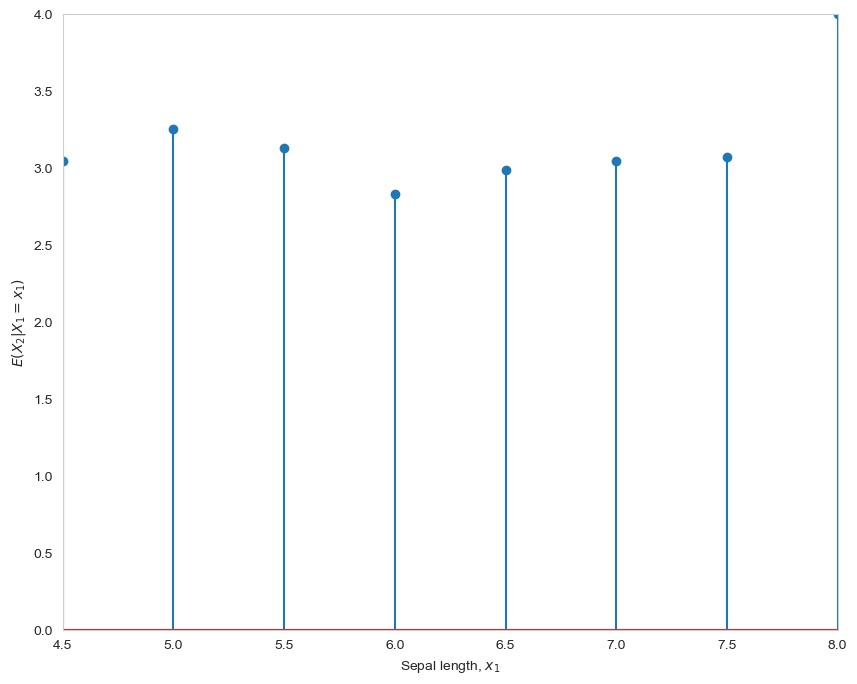

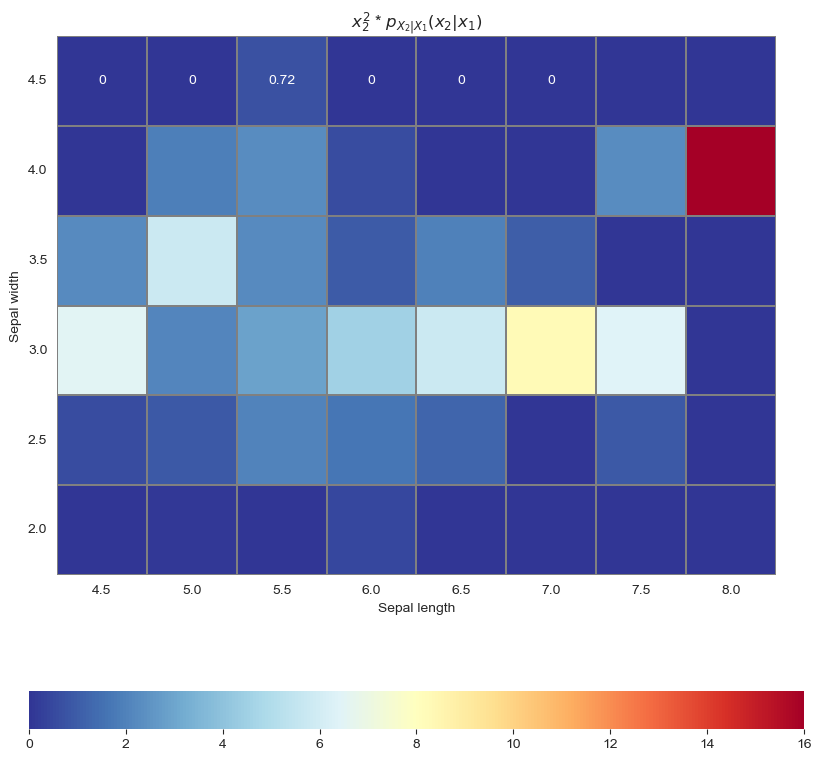

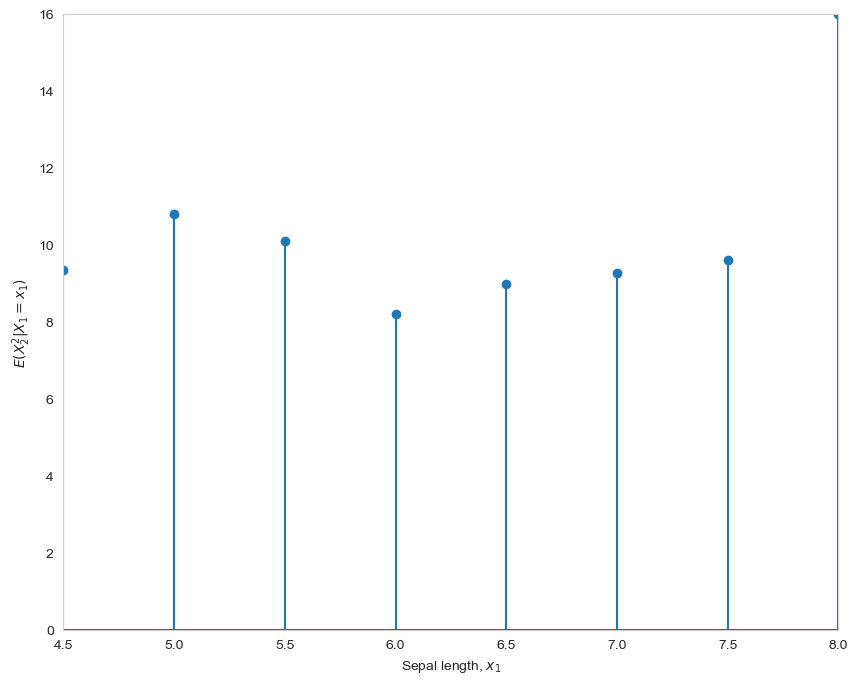

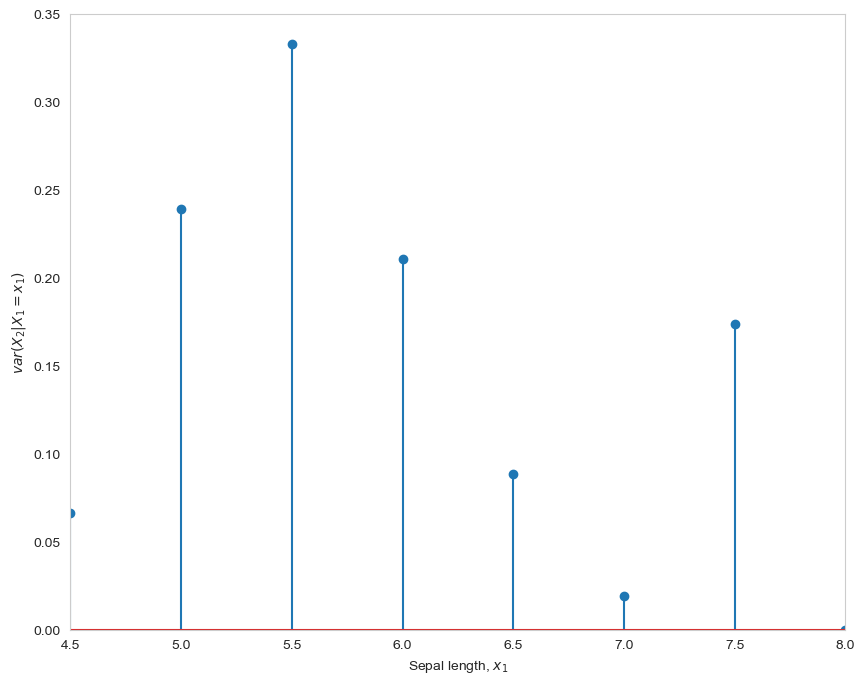

In [11]:
E_X2_given_X1 = X2_array @ conditional_X2_given_X1_matrix

fig, ax = plt.subplots(figsize=(10, 8))
plt.stem(X1_array.T, E_X2_given_X1.T)
plt.xlabel('Sepal length, $x_1$')

plt.grid()
plt.xlim(4.5, 8.0)
plt.ylim(0, 4)
plt.ylabel('$E(X_2 | X_1 = x_1)$')

E_X2 = E_X2_given_X1 @ marginal_X1.T
E_X2_ = X_df_12['sepal_width'].mean()

title = '$x_2^2$ * $p_{X_2 | X_1}(x_2 | x_1)$'
heatmap_sum((X2_array ** 2).T * conditional_X2_given_X1_matrix, sepal_width_array, sepal_length_array, title, 0, 16, 'RdYlBu_r')

E_X2_sq_given_X1 = (X2_array ** 2) @ conditional_X2_given_X1_matrix

fig, ax = plt.subplots(figsize=(10, 8))
plt.stem(X1_array.T, E_X2_sq_given_X1.T)
plt.xlabel('Sepal length, $x_1$')

plt.grid()
plt.xlim(4.5, 8.0)
plt.ylim(0, 16)
plt.ylabel('$E(X_2^2 | X_1 = x_1)$')

# 方差
var_X2_given_X1 = E_X2_sq_given_X1 - E_X2_given_X1 ** 2

fig, ax = plt.subplots(figsize=(10, 8))
plt.stem(X1_array.T, var_X2_given_X1.T)
plt.xlabel('Sepal length, $x_1$')

plt.grid()
plt.xlim(4.5, 8.0)
plt.ylim(0, 0.35)
plt.ylabel('$var(X_2 | X_1 = x_1)$')

# part A: expectation of conditional variances
E_var_X2_given_X1 = var_X2_given_X1 @ marginal_X1.T
E_var_X2_given_X1_each = var_X2_given_X1 * marginal_X1

E_var_X2_given_X1, E_var_X2_given_X1_each

[[0.25712974 0.48884618 0.57670555 0.4587254  0.29740466 0.1381927
  0.41649656 0.        ]]


Text(0, 0.5, '$\\mu_{X_2 | X_1 = x_1} \\pm \\sigma_{X_2 | X_1 = x_1} $')

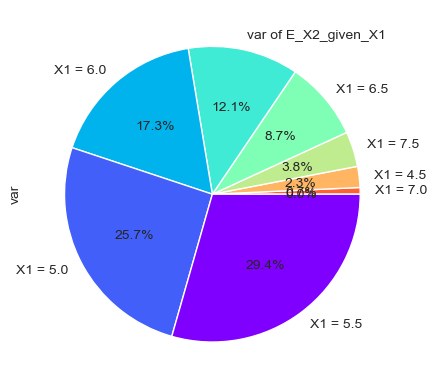

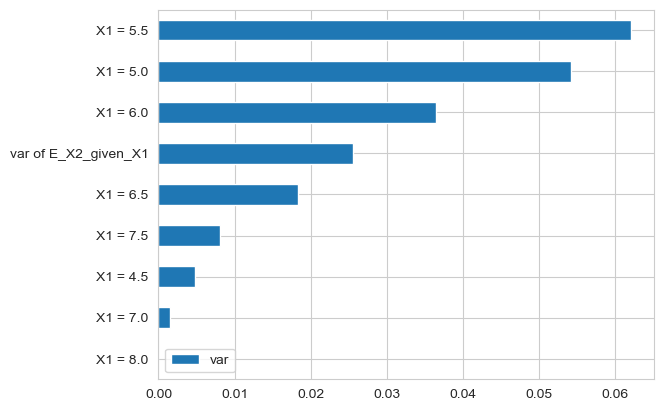

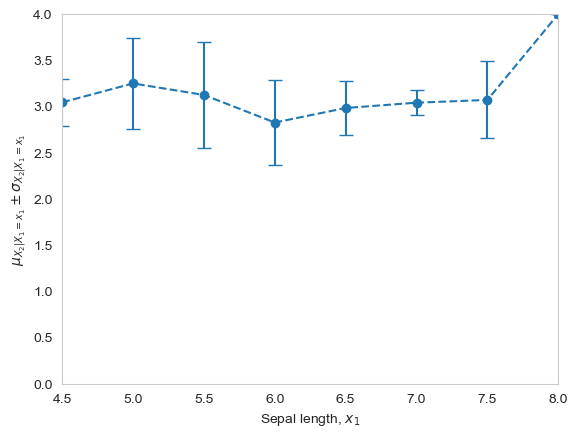

In [16]:
# part B: variance of conditional expectation

var_E_X2_sq_given_X1 = (E_X2_given_X1 - E_X2) ** 2 @ marginal_X1.T

var_X2_total = E_var_X2_given_X1 + var_E_X2_sq_given_X1

var_X2 = np.var(X_df_12['sepal_width'])

import pandas as pd

index = ['X1 = ' + str(x1) for x1 in X1_array[0]]
index.append('var of E_X2_given_X1')

# 创建 DataFrame
var_X2_drill_down_df = pd.DataFrame({'var': np.append(E_var_X2_given_X1_each, var_E_X2_sq_given_X1)}, index=index)
# 按值进行排序
var_X2_drill_down_df.sort_values('var', inplace=True)
# 绘制饼状图
# autopct='%1.1f%%'表示在饼图的每个部分旁边显示百分比，保留一位小数
var_X2_drill_down_df.plot.pie(y='var', autopct='%1.1f%%', legend=False, cmap='rainbow_r')
# 绘制水平条形图
var_X2_drill_down_df.plot.barh(y='var')

# 计算标准差
std_X2_given_X1 = np.sqrt(var_X2_given_X1)
print(std_X2_given_X1)
fig, ax = plt.subplots()

# 绘制误差条图
ax.errorbar(X1_array[0], E_X2_given_X1[0],
            yerr=std_X2_given_X1[0],
            capsize=5,  
            fmt='--o')
# capsize = 5 设置误差条的大小

plt.grid()
plt.xlim(4.5, 8.0)
plt.xlabel('Sepal length, $x_1$')
plt.ylim(0, 4)
plt.ylabel('$\mu_{X_2 | X_1 = x_1} \pm \sigma_{X_2 | X_1 = x_1} $')

Text(0, 0.5, '$\\mu_{X_1 | X_2 = x_2} \\pm \\sigma_{X_1 | X_2 = x_2} $')

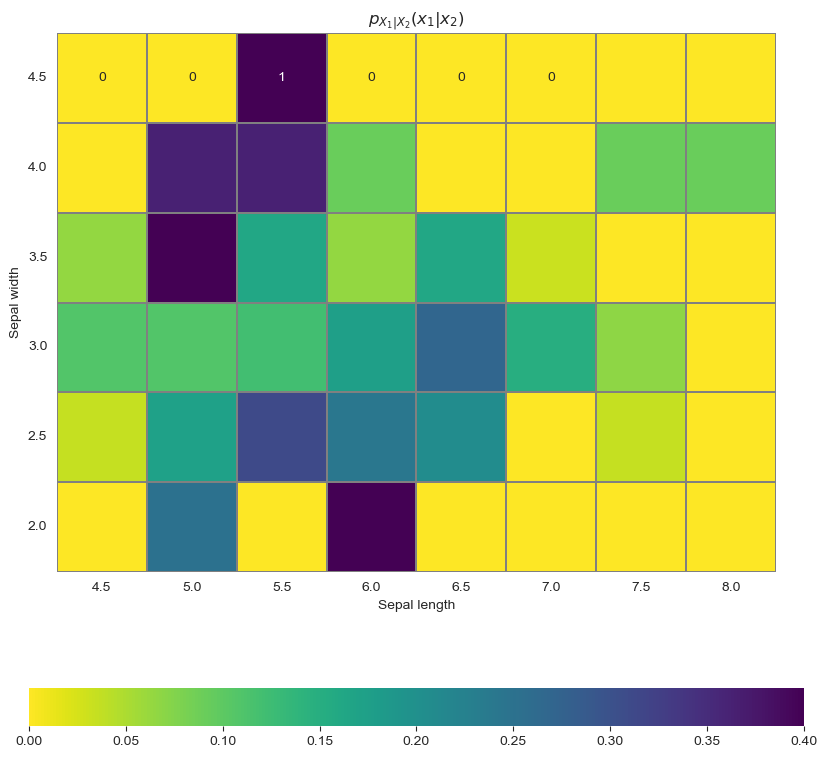

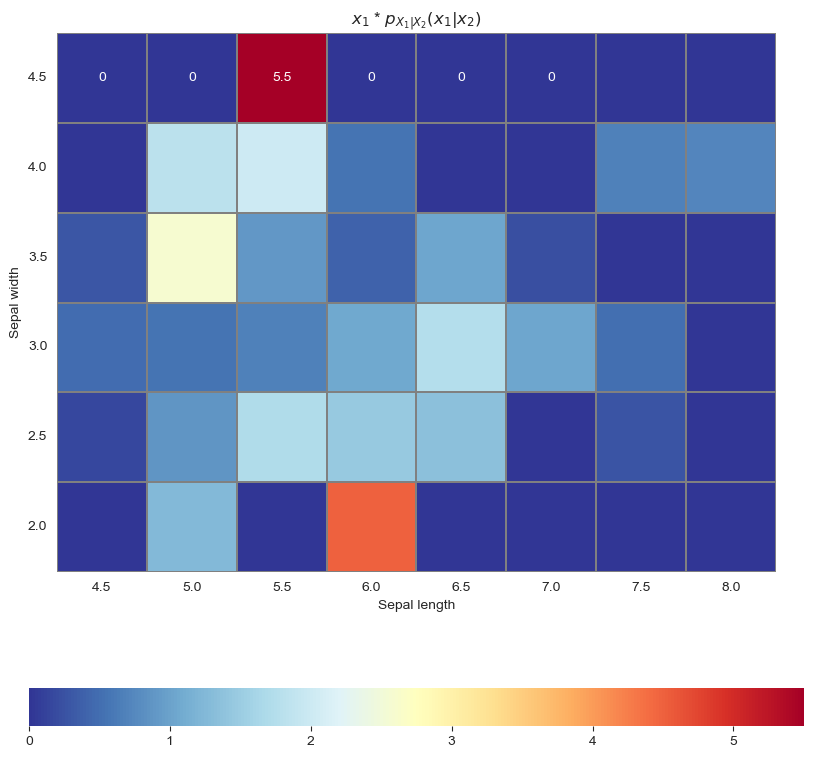

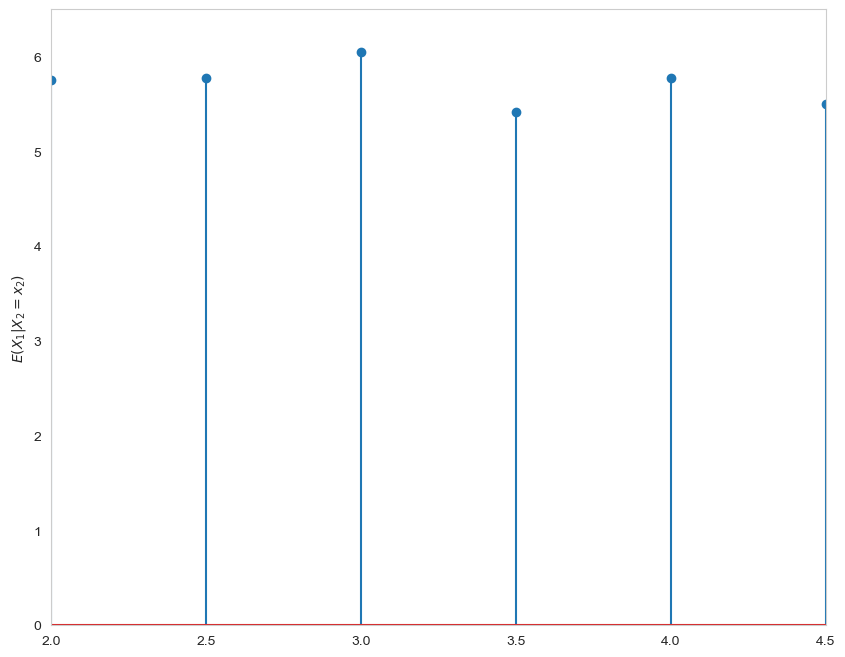

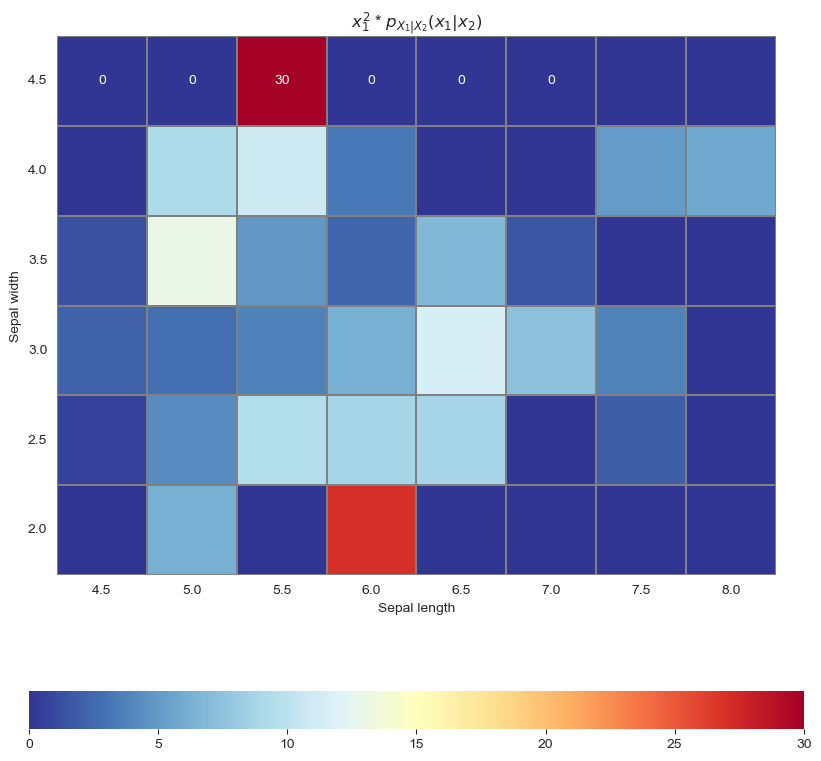

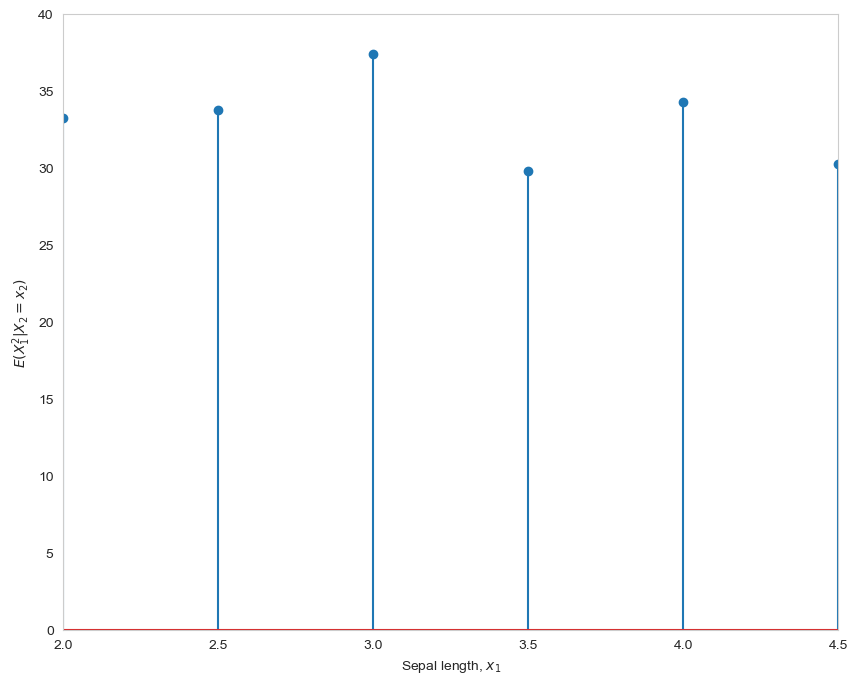

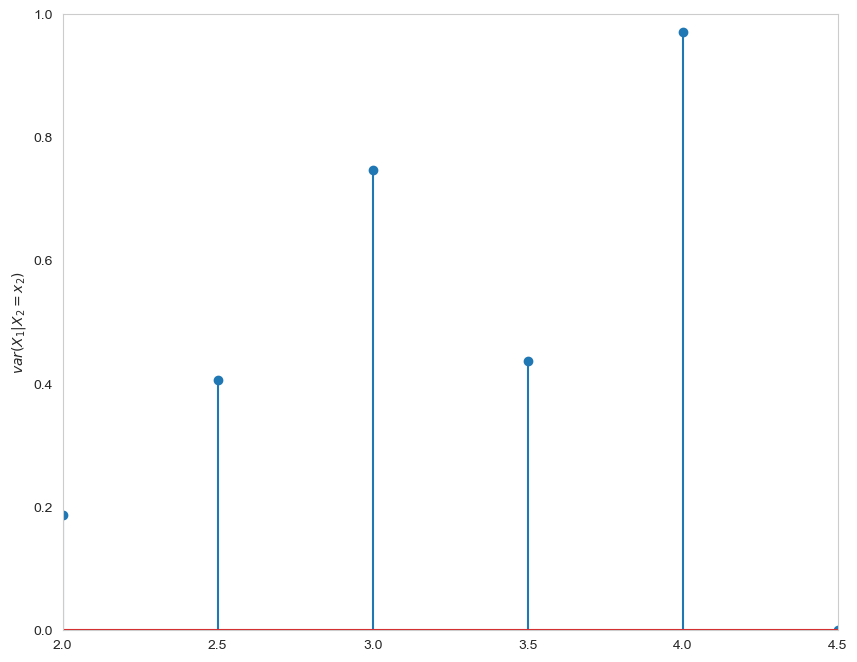

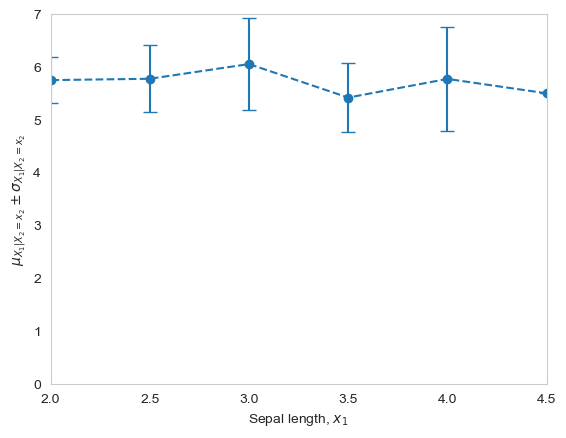

In [15]:
conditional_X1_given_X2_matrix = probability_matrix_ / (
            probability_matrix_.sum(axis=1).reshape(-1, 1) @ np.ones((1, 8)))

title = '$p_{X_1 | X_2}(x_1 | x_2)$'
heatmap_sum(conditional_X1_given_X2_matrix, sepal_width_array, sepal_length_array, title, 0, 0.4, 'viridis_r')

title = '$x_1$ * $p_{X_1 | X_2}(x_1 | x_2)$'
heatmap_sum(X1_array * conditional_X1_given_X2_matrix, sepal_width_array, sepal_length_array, title, 0, 5.5, 'RdYlBu_r')

E_X1_given_X2 = conditional_X1_given_X2_matrix @ X1_array.T

fig, ax = plt.subplots(figsize=(10, 8))
plt.stem(X2_array.T, E_X1_given_X2)
plt.grid()
plt.xlim(2, 4.5)
plt.ylim(0, 6.5)
plt.ylabel('$E(X_1 | X_2 = x_2)$')

title = '$x_1^2$ * $p_{X_1 | X_2}(x_1 | x_2)$'
heatmap_sum((X1_array ** 2) * conditional_X1_given_X2_matrix, sepal_width_array, sepal_length_array, title, 0, 30,
            'RdYlBu_r')

E_X1_sq_given_X2 = conditional_X1_given_X2_matrix @ (X1_array ** 2).T

fig, ax = plt.subplots(figsize=(10, 8))
plt.stem(X2_array.T, E_X1_sq_given_X2)
plt.xlabel('Sepal length, $x_1$')
plt.grid()
plt.xlim(2, 4.5)
plt.ylim(0, 40)
plt.ylabel('$E(X_1^2 | X_2 = x_2)$')

var_X1_given_X2 = E_X1_sq_given_X2 - E_X1_given_X2 ** 2

fig, ax = plt.subplots(figsize=(10, 8))
plt.stem(X2_array.T, var_X1_given_X2)
plt.grid()
plt.xlim(2, 4.5)
plt.ylim(0, 1)
plt.ylabel('$var(X_1 | X_2 = x_2)$')

std_X1_given_X2 = np.sqrt(var_X1_given_X2)

fig, ax = plt.subplots()

# 绘制误差条图
ax.errorbar(X2_array[0], E_X1_given_X2.T[0],
            yerr=std_X1_given_X2.T[0],
            capsize=5,
            fmt='--o')

plt.grid()
plt.xlim(2, 4.5)
plt.xlabel('Sepal length, $x_1$')
plt.ylim(0, 7)
plt.ylabel('$\mu_{X_1 | X_2 = x_2} \pm \sigma_{X_1 | X_2 = x_2} $')

Iris class label:
setosa
E_X1_given_Y: [[5.01]]
E_X1_sq_given_Y: [[25.225]]
var_X1_given_Y: [[0.1249]]
std_X1_given_Y: [[0.35341194]]
E_X2_given_Y: [[3.43]]
E_X2_sq_given_Y: [[11.925]]
var_X2_given_Y: [[0.1601]]
std_X2_given_Y: [[0.40012498]]
Iris class label:
versicolor
E_X1_given_Y: [[5.91]]
E_X1_sq_given_Y: [[35.215]]
var_X1_given_Y: [[0.2869]]
std_X1_given_Y: [[0.53563047]]
E_X2_given_Y: [[2.78]]
E_X2_sq_given_Y: [[7.84]]
var_X2_given_Y: [[0.1116]]
std_X2_given_Y: [[0.33406586]]
Iris class label:
virginica
E_X1_given_Y: [[6.59]]
E_X1_sq_given_Y: [[43.785]]
var_X1_given_Y: [[0.3569]]
std_X1_given_Y: [[0.59741108]]
E_X2_given_Y: [[2.98]]
E_X2_sq_given_Y: [[9.02]]
var_X2_given_Y: [[0.1396]]
std_X2_given_Y: [[0.37363083]]


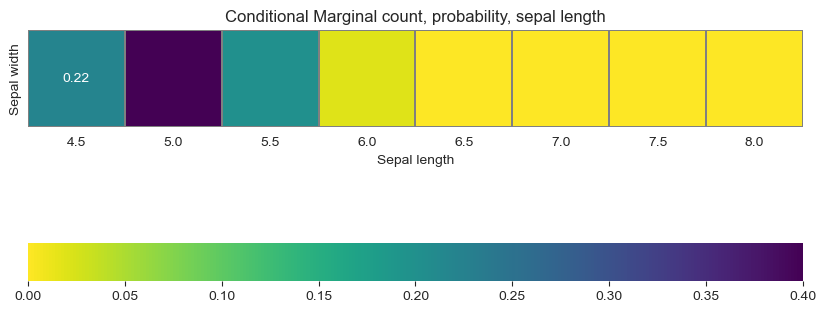

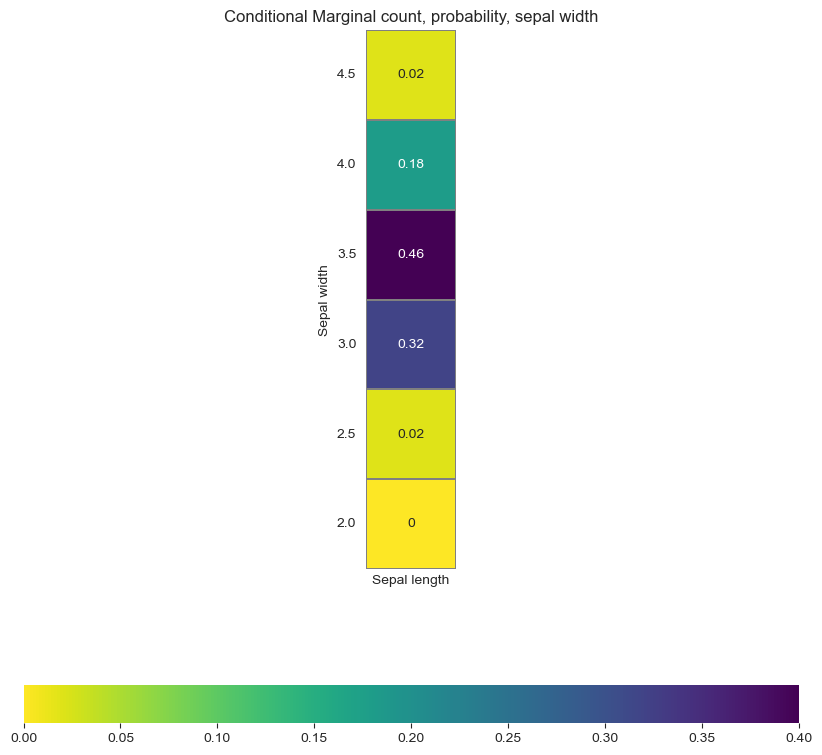

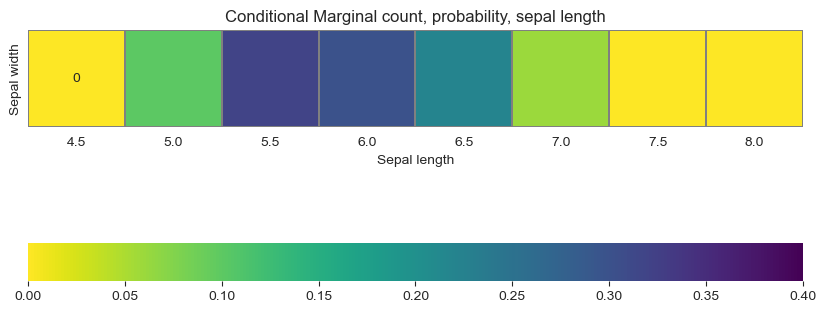

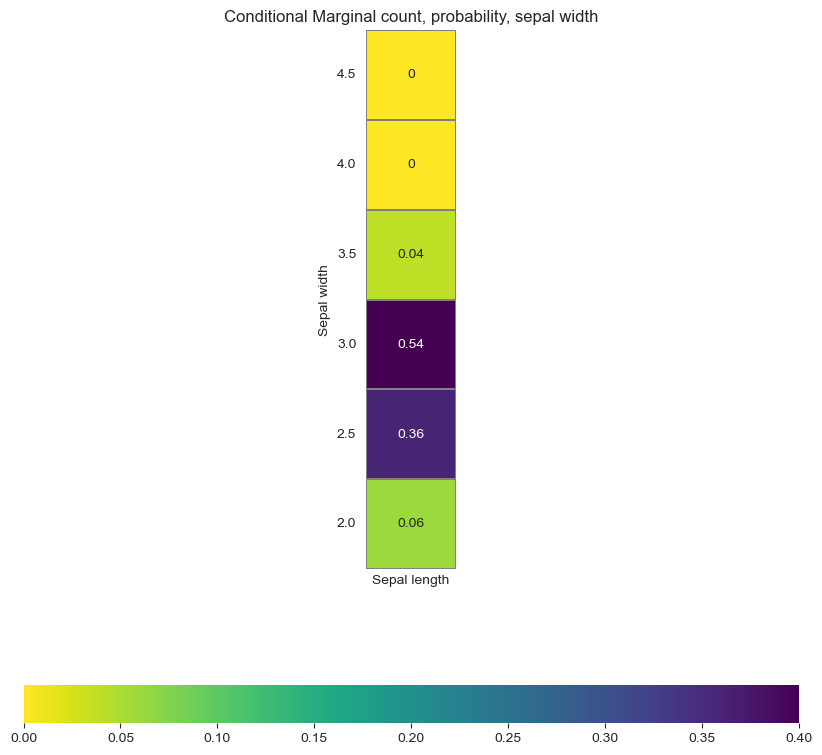

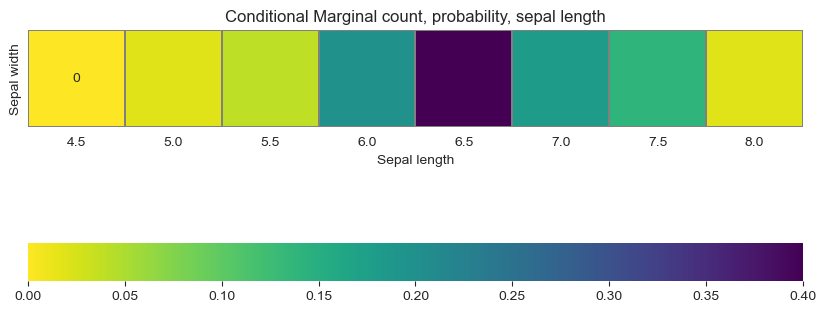

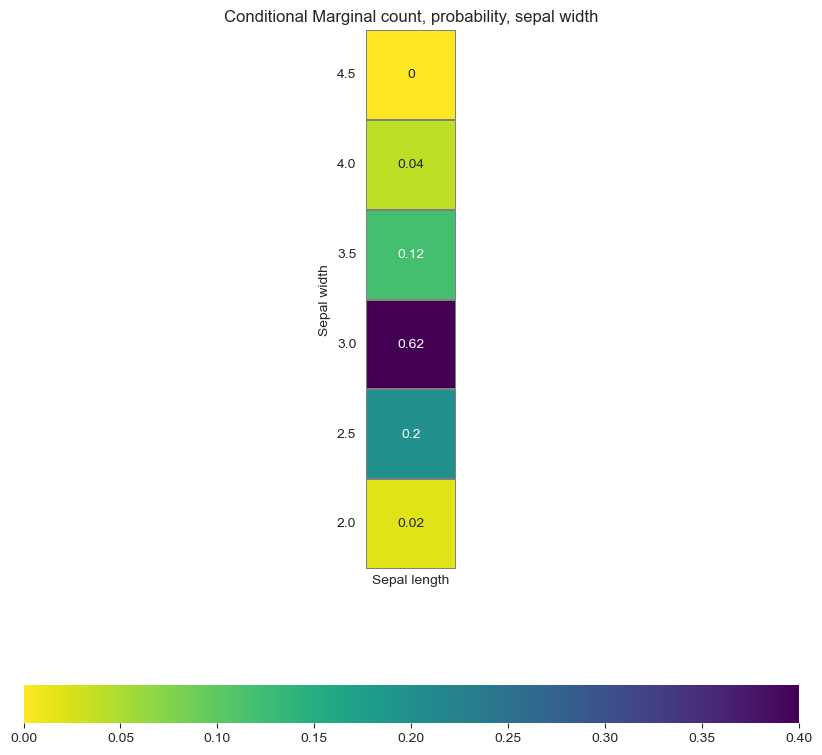

In [17]:
Y_array = ['setosa', 'versicolor', 'virginica']
# iris class labels

for Given_Y in Y_array:
    print('====================')
    print('Iris class label:')
    print(Given_Y)

    X_df_12_given_Y = X_df[['sepal_length', 'sepal_width', 'species']]
    X_df_12_given_Y['count'] = 1
    # ~ 表示取反
    X_df_12_given_Y.loc[~(X_df_12_given_Y.species == Given_Y), 'count'] = np.nan
    X_df_12_given_Y = X_df_12_given_Y[['sepal_length', 'sepal_width', 'count']]
    frequency_matrix_given_Y = X_df_12_given_Y.groupby(['sepal_length', 'sepal_width']).count().unstack(level=0)
    frequency_matrix_given_Y.columns = frequency_matrix_given_Y.columns.droplevel(0)
    # 将 nan 赋值为 0
    frequency_matrix_given_Y = frequency_matrix_given_Y.fillna(0)
    frequency_matrix_given_Y = frequency_matrix_given_Y.iloc[::-1]

    probability_matrix_given_Y = frequency_matrix_given_Y / frequency_matrix_given_Y.sum().sum()

    # Conditional Marginal, sepal length X1 given Y

    prob_sepal_length_given_Y = probability_matrix_given_Y.sum(axis=0).to_numpy().reshape((1, -1))

    title = 'Conditional Marginal count, probability, sepal length'
    heatmap_sum(prob_sepal_length_given_Y, [], sepal_length_array, title, 0, 0.4, 'viridis_r')

    E_X1_given_Y = prob_sepal_length_given_Y @ sepal_length_array.reshape(-1, 1)
    print('E_X1_given_Y: ' + str(E_X1_given_Y))

    E_X1_sq_given_Y = prob_sepal_length_given_Y @ (sepal_length_array ** 2).reshape(-1, 1)
    print('E_X1_sq_given_Y: ' + str(E_X1_sq_given_Y))

    var_X1_given_Y = E_X1_sq_given_Y - E_X1_given_Y ** 2
    print('var_X1_given_Y: ' + str(var_X1_given_Y))

    std_X1_given_Y = np.sqrt(var_X1_given_Y)
    print('std_X1_given_Y: ' + str(std_X1_given_Y))

    # Conditional Marginal, sepal width X2 given Y

    prob_sepal_width_given_Y = probability_matrix_given_Y.sum(axis=1).to_numpy().reshape((-1, 1))

    title = 'Conditional Marginal count, probability, sepal width'
    heatmap_sum(prob_sepal_width_given_Y, sepal_width_array, [], title, 0, 0.4, 'viridis_r')

    E_X2_given_Y = sepal_width_array.reshape(1, -1) @ prob_sepal_width_given_Y
    print('E_X2_given_Y: ' + str(E_X2_given_Y))

    E_X2_sq_given_Y = (sepal_width_array ** 2).reshape(1, -1) @ prob_sepal_width_given_Y
    print('E_X2_sq_given_Y: ' + str(E_X2_sq_given_Y))

    var_X2_given_Y = E_X2_sq_given_Y - E_X2_given_Y ** 2
    print('var_X2_given_Y: ' + str(var_X2_given_Y))

    std_X2_given_Y = np.sqrt(var_X2_given_Y)
    print('std_X2_given_Y: ' + str(std_X2_given_Y))

    print('====================')